## Previously defined functions

In [ ]:
from mock_dp_library import *
from numpy import *
np.random.seed(12345)

def sigmoid(x):
	return 1 / (1 + exp(-x))

## Here is the likelihood function for a Logit
def logit_neg_log_likelihood(beta, data):
	"""negative log likelihood function for a logit
	:param beta: 1darray of [intercept, slope]
	"""
	x, y = data.T

	probability = sigmoid(beta[0] + beta[1] * x)	
	log_likelihood = y * log(probability) + (1 - y) * log(1 - probability)

	return -log_likelihood

## Run with actual data

In [ ]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv")

# define public information
n = len(data)            # in this case, dataset length is considered public, and is not protected
educ_bounds = (1., 16.)  # easily guessable without looking at the data
data = data[['educ', 'married']].values.astype(float)


In [ ]:
from sklearn.linear_model import LogisticRegression

educ = data[:, 0]
married = data[:, 1]
model = LogisticRegression().fit(X = educ[:, None], y=married)
beta = np.array([model.intercept_[0],model.coef_[0, 0]]) 

print(beta)

[-0.61997468  0.07828177]


## Stochastic Gradient Descent

Based on the paper [Deep Learning with Differential Privacy](https://arxiv.org/pdf/1607.00133.pdf). Instead of using a moment's accountant, this implementation is simplified (at a significant cost of efficiency) to use parallel composition over batches, and basic composition to estimate each parameter's gradient independently.

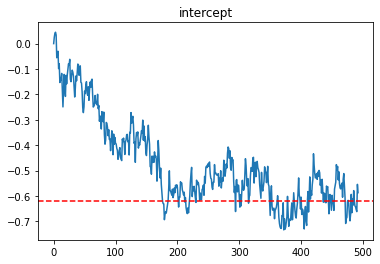

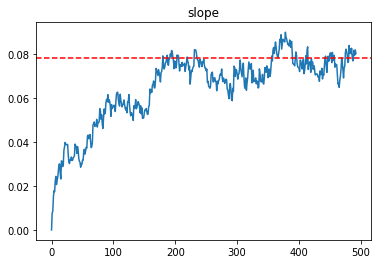

In [ ]:
# Calculate the gradient at a point in the parameter space
def calc_clamped_gradient(X, C, theta, fun):
	"""
	:param X: data
	:param C: clipping norm bound
	:param theta: learned param
	:param fun: loss function to optimize"""

	dx = 0.0001
	bounds = [-C, C]

	out1 = fun(beta=theta, data=X)
	out2 = fun(beta=theta + [0, dx], data=X)
	out3 = fun(beta=theta + [dx, 0], data=X)

	Del_1 = (out3-out1) / dx 
	Del_1_clamped = clamp(Del_1, bounds=bounds)    
	mean_Del_1 = Del_1_clamped.mean()
    
	Del_2 = (out2-out1) / dx
	Del_2_clamped = clamp(Del_2, bounds=bounds) 
	mean_Del_2 = Del_2_clamped.mean()

	return np.array([mean_Del_1, mean_Del_2])



N = len(educ)
L = round(sqrt(N))     # This is the recommended batch size

steps = np.ceil(N / L)   # Happens to be ~L 

# global epsilon
epsilon = 15
delta = 1e-6

theta = np.array([0,0])   # Starting parameters
C = 10			          # Interval to clip over
nu = [1, 0.01]            # Learning speeds


history = [theta]


## Run one epoch of SGD

# randomly partition the data
np.random.shuffle(data)
for batch in np.array_split(data, steps):


	sensitive_grad = calc_clamped_gradient(X=batch, C=C, theta=theta, fun=logit_neg_log_likelihood)
	
	# NOTE: len(batch) ~ L, but not exactly, as the dataset length is usually not evenly divisible
	#       use len(batch) so that epsilon is not underestimated on the last batch
	# mean sensitivity
	sensitivity = 2 * C / len(batch)  # 2 * C / L

	# by parallel composition, at each training step we consume epsilon on independent data partitions
	# split epsilon, delta amongst DP means for two parameters
	functional_epsilon = epsilon / 2 # epsilon * sqrt(steps) 
	functional_delta = delta / 2
	scale = (sensitivity / functional_epsilon) * np.sqrt(2 * np.log(1.25 / functional_delta)) 

	dp_grad = sensitive_grad + gaussian(scale=scale, shift=0, size=2) 
	theta = theta - dp_grad * nu

	history.append(theta)

history = np.array(history)

import matplotlib.pyplot as plt

plt.plot(np.arange(len(history)), history[:, 0])
plt.title("intercept")
plt.axhline(y=model.intercept_[0], color="red", linestyle="--")
plt.show()

plt.plot(np.arange(len(history)), history[:, 1])
plt.title("slope")
plt.axhline(y=model.coef_[0, 0], color="red", linestyle="--")
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>